In [ ]:
# PTRnet Ablation Study Results

In [1]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from scipy.interpolate import make_interp_spline

import vis_utils
from custom_colors import blue_shades

font_path = r'C:\Users\Felix\AppData\Local\Microsoft\Windows\Fonts\SourceSansPro-Regular.ttf'
fm.fontManager.addfont(font_path)
source_sans_pro = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = source_sans_pro.get_name()

In [2]:
STORE = True
# STORE = False

In [3]:
# Load datafile
df_raw = pd.read_csv("data/runs-12_34_50-10-Jun-25-PTRnet-final.csv")
df_raw.loc[:, "pretrain"] = df_raw.experiment.str.contains("pretrain")
df_raw = df_raw[df_raw.pretrain == False]
df_raw.loc[:, "run_id_temp"] = df_raw.experiment.str.split("/").str[2]
df_raw.loc[:, "run_id"] = df_raw.run_id_temp.str.split("_").str[0]

In [4]:
df_raw

,run,experiment,AUC_val,AUC_train,nr_params,avg_epoch_time,nr_flops,training_time_min,date,duration,...,model_config.optuna.n_trials,model_config.optuna.study_name,model_config.scale_targets,model_config.seq_encoding,model_config.seq_only,model_config.test_data_file,model_config.val_data_file,pretrain,run_id_temp,run_id
0,Run: 0163aaa98f844cbab63d7434,binary/ptrnet/31_ptrnet_freq,0.68598397,0.71945254,272033,0.404033,13556666368,13.3331,"11:45:21 · 10 Jun, 25",26min 44sec,...,400,"""final_1""",False,"""embedding""",False,"""test_9.0k_data.pkl""","""val_9.0k_data.pkl""",False,31_ptrnet_freq,31
2,Run: 8d0b651a26384dd9baf90115,binary/ptrnet/30_ptrnet_freq,0.68392869,0.72148586,272033,0.405883,13556666368,21.9177,"00:33:41 · 10 Jun, 25",34min 29sec,...,400,"""final_1""",False,"""embedding""",True,"""test_9.0k_data.pkl""","""val_9.0k_data.pkl""",False,30_ptrnet_freq,30
3,Run: 36e27b83c3db4e4e9d58f5b3,binary/ptrnet/29_ptrnet_freq,0.68674553,0.71558985,611905,0.460457,53644118016,21.6415,"00:05:25 · 10 Jun, 25",32min 47sec,...,400,"""final_1""",False,"""embedding""",False,"""test_9.0k_data.pkl""","""val_9.0k_data.pkl""",False,29_ptrnet_freq,29
4,Run: 2c0dbcfb19fa418bbb2240dc,binary/ptrnet/28_ptrnet_freq,0.67996119,0.70356534,508399,0.784276,39687928320,13.3327,"23:42:25 · 09 Jun, 25",47min 42sec,...,400,"""final_1""",False,"""ohe""",False,"""test_9.0k_data.pkl""","""val_9.0k_data.pkl""",False,28_ptrnet_freq,28
5,Run: e940d23f7477445c85c54b2e,binary/ptrnet/27_ptrnet_freq,0.67980306,0.75427224,192609,0.273536,8947148800,10.6679,"23:35:11 · 09 Jun, 25",20min 13sec,...,400,"""final_1""",False,"""embedding""",False,"""test_9.0k_data.pkl""","""val_9.0k_data.pkl""",False,27_ptrnet_freq,27
6,Run: 76de08b7ba6e4a5880844a80,binary/ptrnet/44_ptrnet,0.68407747,0.71370151,269857,0.396094,13556514816,13.0711,"23:11:24 · 09 Jun, 25",26min 47sec,...,400,"""final_1""",False,"""embedding""",False,"""test_9.0k_data.pkl""","""val_9.0k_data.pkl""",False,44_ptrnet,44
7,Run: 5fbdb940ed7646a7b8f5b7f4,binary/ptrnet/26_ptrnet_freq,0.68499404,0.72131195,272033,0.400308,13556666368,15.6120,"23:02:02 · 09 Jun, 25",27min 38sec,...,400,"""final_1""",False,"""embedding""",False,"""test_9.0k_data.pkl""","""val_9.0k_data.pkl""",False,26_ptrnet_freq,26


In [5]:
# Assign runnames to ids
run_names = {
    26: "baseline (tuned PTRnet)",
    44: "- codon frequencies",
    27: "- AUG alignment",
    28: "OHE of inputs",
    29: "concat tissue embeddings",
    30: "sequence only",
    31: "+ pretraining",
}

df_raw["run_id"] = df_raw["run_id"].astype(int)
df_raw.loc[:, "name"] = df_raw.run_id.map(run_names)

In [6]:
df = df_raw[["run", "run_id", "name", "AUC_train", "AUC_val", "F1_val", "Precision_val", "Recall_val", "Accuracy_val"]].copy()

In [7]:
# rename columns from _val to _test
df.rename(columns={
    "AUC_val": "AUC_test",
    "F1_val": "F1_test",
    "Precision_val": "Precision_test",
    "Recall_val": "Recall_test",
    "Accuracy_val": "Accuracy_test"
}, inplace=True)

In [8]:
# convert to float
cols_to_convert = [col for col in df.columns if col not in ['run', "run_id", "name"]]
df.loc[:, cols_to_convert] = df[cols_to_convert].astype(float)

In [10]:
df.sort_values(by="AUC_test", ascending=True, inplace=True)
df

,run,run_id,name,AUC_train,AUC_test,F1_test,Precision_test,Recall_test,Accuracy_test
5,Run: e940d23f7477445c85c54b2e,27,- AUG alignment,0.754272,0.679803,0.62876,0.638124,0.619667,0.635052
4,Run: 2c0dbcfb19fa418bbb2240dc,28,OHE of inputs,0.703565,0.679961,0.62403,0.638427,0.610268,0.633249
2,Run: 8d0b651a26384dd9baf90115,30,sequence only,0.721486,0.683929,0.6181,0.642969,0.595083,0.633249
6,Run: 76de08b7ba6e4a5880844a80,44,- codon frequencies,0.713702,0.684077,0.634864,0.629893,0.639913,0.632889
7,Run: 5fbdb940ed7646a7b8f5b7f4,26,baseline (tuned PTRnet),0.721312,0.684994,0.62853,0.637649,0.619667,0.634692
0,Run: 0163aaa98f844cbab63d7434,31,+ pretraining,0.719453,0.685984,0.631579,0.643178,0.62039,0.639019
3,Run: 36e27b83c3db4e4e9d58f5b3,29,concat tissue embeddings,0.71559,0.686746,0.601174,0.65529,0.555315,0.632528


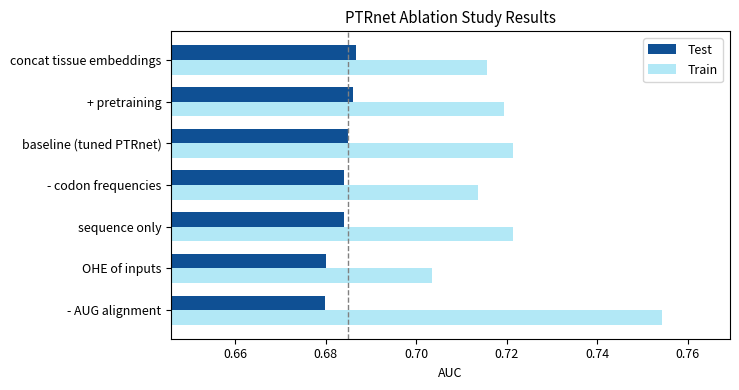

In [13]:
fig, ax = plt.subplots(figsize=(7.5, 4))
bar_height = 0.35
y = range(len(df))

# Bars with spacing
ax.barh([i + bar_height / 2 for i in y], df["AUC_test"], height=bar_height, label='Test', color=blue_shades[4])
ax.barh([i - bar_height / 2 for i in y], df["AUC_train"], height=bar_height, label='Train', color=blue_shades[0])

# Labels and legend
ax.set_yticks(y)
ax.set_yticklabels(df.name)
ax.set_xlabel("AUC")
ax.set_title("PTRnet Ablation Study Results")
ax.legend()
# ax.set_xlim(0.5, max(df["AUC_test"].max(), df["AUC_train"].max()) * 1.035)
ax.set_xlim(min(df["AUC_test"].min(), df["AUC_train"].min()) * 0.95, max(df["AUC_test"].max(), df["AUC_train"].max()) * 1.02)
# add a vertical grey line at the baseline AUC value
baseline_auc = df[df.run_id == 26]["AUC_test"].values[0]
ax.axvline(baseline_auc, color="grey", linestyle="--", label="Baseline AUC", lw=1)
plt.tight_layout()

if STORE:
    plt.savefig(os.getenv("OUTPUT_DIR") + f"/ptrnet_ablation_barplot.pdf", format="pdf", bbox_inches="tight")

plt.show()

## All metrics table

In [ ]:
# See benchmark_test_results.ipynb